# **M**odel **U**ncertainty-based Data **Augment**ation (muAugment)

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Mariana Alves | <a href="https://supaerodatascience.github.io/deep-learning/">https://supaerodatascience.github.io/deep-learning/</a>

## Preliminary work for colab

**This notebook was written in google colab, so it is recommended that you run it in colab as well.**

<a href="https://colab.research.google.com/github/Mariana-Andrade-Alves/muAugment/blob/main/muAugment.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Before starting to work on the notebook, make sure you `change the Runtime type` to **GPU**, in the `Tool` drop menu.

In colab, please execute first the following cells, to retrieve the GitHub repository content. 

In [ ]:
!git clone https://github.com/Mariana-Andrade-Alves/muAugment/

## Preliminary Imports

In [ ]:
# !pip install matplotlib

In [ ]:
# !pip install torch torchvision

In [1]:
import torch
import torchvision
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Overview of Data Augmentation

Modern machine learning models, such as deep neural networks, may have billions of parameters and, consequently, require massive labeled training datasets, which are often not available. In order to avoid the **problem of data scarcity** in such models, data augmentation has become the standard technique used in nearly every state-of-the-art model in applications such as **image** and **text classification**.

> **Data augmentation refers to the technique of artificially expanding labelled training datasets by generating new data through transformation functions.**






Data augmentation schemes often rely on the composition of a set of simple transformation functions (TFs) such as rotation and flip. 

<img src="./img/transforms.png" width='800'>

"Label-invariant transformations." [torchvision.transforms docs](https://pytorch.org/vision/stable/transforms.html#transforms-on-pil-image-only)

As was briefly discussed in the [computer vision class](https://github.com/SupaeroDataScience/deep-learning/blob/main/vision/1_hands_on.ipynb), when chosen carefully, data augmentation schemes tuned by human experts can improve model performance. However, such heuristic strategies in practice can cause large variances in end model performance, and may not produce parameterizations and compositions needed for state-of-the-art models. In addition, they are extremely laborious.

### Automated Data Augmentation Schemes

Instead of performing manual search, automated data augmentation approaches hold promise to search for more powerful parameterizations and compositions of transformations. 

The biggest difficulty with automating data augmentation is how to search over the space of transformations. This can be prohibitively expensive due to the large number of transformation functions in the search space. 

> **How can we design algorithms that explore the space of transformation functions efficiently and effectively, and find augmentation strategies that can outperform human-designed heuristics?**

The folklore wisdom behind data augmentation is that adding more labeled data improves generalization, i.e. the performance of the trained model on unseen test data. However, even for simpler models, **it is not well-understood how training on augmented data affects the learning process, the parameters, and the decision surface of the resulting model**.

<details class="alert alert-danger">
    <summary markdown="span"><b>Extra information on the Adversarial AutoAugment Scheme previsouly discussed in class (click to expand)</b></summary>

One of the current state-of-the-art algorithms in terms of performance is [Adversarial AutoAugment](https://openreview.net/pdf?id=ByxdUySKvS), which makes use of [GANs](https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf), already presented in a previous [class](https://github.com/SupaeroDataScience/deep-learning/tree/main/GAN), to generate new data, rather than using the traditional heuristic transformations presented above. 

<img src="./img/AdvAA.png" width='800'>

Li et al. "Adversarial AutoAugment training framework (Zhang et al. 2019) is formulated as an adversarial min-max game." [Automating the Art of Data Augmentation.](https://hazyresearch.stanford.edu/blog/2020-02-26-data-augmentation-part2) 2020.

Although proven effective, this technique is still computationally expensive. Additionally, despite its rapid progress, this technique does not allow for a theoretical understanding of the benefits of a given transformation.
</details>



## How should we think of the effects of applying a transformation?

### Intuition for Linear Transformations

Suppose we are given $n$ training data points $x_1,...,x_n \in \mathbb{R}^p$ as $X \in \mathbb{R}^{n\times p}$ with labels $Y\in \mathbb{R}^n$.

> In this setting, the labels obey the true linear model under ground parameters $\beta \in \mathbb{R}^p$, i.e. $$Y = X \beta + \epsilon,$$ where $\epsilon \in \mathbb{R}^n$  denotes i.d.d. random noise with mean zero and variance $\sigma²$.

Importantly, we assume that $p>n$, hence the span of the training data does not contain the entire space of $\mathbb{R}^p$.

Let's suppose we have an estimator $\hat{\beta}$ for the linear model $\beta \in \mathbb{R}^p$. The error of that given estimator is 

> $$e(\hat{\beta}) = \underbrace{\lVert \underset{
  \epsilon}{\mathbb{E}}[\hat{\beta}]-\beta\rVert^2}_{bias} + \underbrace{\lVert\hat{\beta} - \underset{\epsilon}{\mathbb{E}}[\beta] \rVert^2}_{variance}$$

where the bias part, intuitively, measures the intrinsic error of the model after taking into account the randomness which is present in $\hat{\beta}$.


### Label-Invariant Transformations

For a matrix $F \in \mathbb{R}^{p\times p}$, we say that $F$ is a label-invariant transformation over $\chi \subseteq \mathbb{R}^p $ for $\beta \in \mathbb{R}^p$ if $$x^\top\beta = (Fx)^\top\beta, \quad \text{ for any } x \in \chi.$$

> In simpler words, a label-invariant transformation will not alter the label $y$ of a given data point $x$.

**But what is the effect of such a transformation?**

Given a training data point $(x,y)$, let $(x^{aug},y^{aug})$ denote the augmented data where $y^{aug} = y$. 

> Intuitively, based on our training data $(X,Y)$, we can infer the label of any data point within $P_X$, where $P_X$ denotes the projection matrix onto the row of $X$. [EXPLAIN; VISUALIZE]

In simpler words, we know the information cointained in the training data. [EXPLAIN; VISUALIZE]

* If $x^{aug}$satisfies that $P_X x^{aug} = 0$, then adding $(x^{aug},y^{aug})$ **does not provide new information**. [EXPLAIN; VISUALIZE]

* On the other hand, if $P^\bot_X x^{aug} \neq 0$, then adding $x^{aug}$ **expands the subspace over which we can obtain accurate estimations**. The added direction corresponds to $P^\bot_X x^{aug}$ and contributes to the improvement of the bias term of the error function of our model $\hat{\beta}$. [EXPLAIN; VISUALIZE]

A more powerful result presented in the [muAugment paper](https://hazyresearch.stanford.edu/blog/2020-02-26-data-augmentation-part2), which we will not go into detail in the class, shows that 
* the higher the loss $l_{\hat{\beta}}(x^{aug},y^{aug})$ of an augmented data point $(x^{aug},y^{aug})$ under $\hat{\beta}$, the bigger the reduction of the estimation error.

> In an intuitive sense, an augmented data point with a small loss means the model has already learned how to predict that type of data well, so if trained on it further, the model will only pick up incidental, possibly spurious patterns — overfitting. Conversely,  an augmented data point with a large loss means the model has not learned the general mapping between the type of data and its target yet, so we need to train more on those kinds of data points.

Additional results regarding **label-mixing transformations** were obtained in the [muAugment paper](https://hazyresearch.stanford.edu/blog/2020-02-26-data-augmentation-part2). These results will not be discussed in the class.

## Uncertainty-based Sampling Scheme

In order to take advantage of the last result presented, the **muAugment** algorithm was developped. The algorithm is as follows:

* In a first step, for each data point, **C** compositions of **L** linear transformations are randomly sampled and fed to the learning model (in this example a neural network).  

* In a second step, the **S** transformed samples with the highest losses are picked for training the model and a backpropagation is performed using those samples.

> **The intuition behind the sampling scheme is that these transformed samples that have the largest losses should also provide the most information.**

**The model learns more generalizable patterns, because the algorithm assures extra fitting on the "hard" augmentations while skipping the easy ones.**

<img src="./img/dauphin.png" width='800'>

Senwu. "Uncertainty-based random Sampling Scheme for Data Augmentation. Each transformation function is randomly sampled from a pre-defined set of operations." [Dauphin](https://github.com/senwu/dauphin) 2020.

<details class="alert alert-danger">
    <summary markdown="span"><b>Comparison to Adversarial Autoaugment (click to expand)</b></summary>

The idea behing this sampling scheme is conceptually similar to [Adversarial Autoaugment](https://openreview.net/pdf?id=ByxdUySKvS). However, while in the case of Adversarial Autoaugment, an additional adversarial network is used to generate augmented samples with large losses, in the current case, the model uses the training network itself to generate augmented samples.
</details>




Our goal today is to implement the **muAugment** algorithm and evaluate its performance.

### The Dataset: FashionMNIST

The dataset we will use for this application is the FashionMNIST dataset.  We'll download this dataset and make batching data loaders.

In [4]:
batch_size = 4
n_images = 10 if (batch_size>10) else batch_size

# data must be normalized between -1 and 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

full_trainset = FashionMNIST(root='../data', train=True, download=True, transform=transform)
trainset, full_validset = torch.utils.data.random_split(full_trainset, (10000, 50000)) # 10000 images for the training set
validset, _ = torch.utils.data.random_split(full_validset, (1000, 49000)) # 1000 images for the validation set

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
validloader = DataLoader(validset, batch_size=64, shuffle=True, num_workers=2)

testset = FashionMNIST(root='../data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

We can verify the normalization of our data.

In [5]:
images,labels = next(iter(trainloader))
images.min(),images.max()

(tensor(-1.), tensor(1.))

Let's look at some example images from the FashionMNIST set.

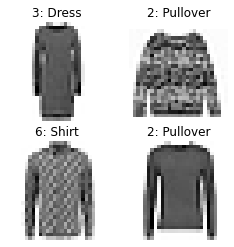

In [6]:
# get the first batch of images and labels
labels_text = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

plt.figure(figsize=(n_images,4))
for i in range(n_images):
    l = labels[i].numpy()
    plt.subplot(2, n_images/2, i+1)
    plt.title('%d: %s' % (l, labels_text[l]))
    plt.imshow(images[i].numpy()[0], cmap='Greys')
    plt.axis('off')

### The Model

As mentioned above, the advantage of the **muAugment** algorithm is that it uses the learning model to automate data augmentation. The goal is to generate data which will improve our training model.

In today's example, we wish to learn to classify images into 10 possible labels:

In [7]:
labels_text

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In order to do this, the training model we will use is a convolutional neural network, presented during a [previous class](https://github.com/SupaeroDataScience/deep-learning/blob/main/deep/PyTorch%20Ignite.ipynb).

In [8]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(64*6*6,600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = x.view(-1,64*6*6)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return F.log_softmax(x,dim=1)

### Training

In order to train the model, we must first create it and define the loss function and optimizer.

In [9]:
#creating model for original data
model_original = CNN()
# creating model for augmented data
model = CNN()
# moving models to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model_original.to(device)

CNN(
  (convlayer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convlayer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [10]:
lr = 0.001 # learning rate
# defining optimizer and loss for original model
optimizer_original = torch.optim.SGD(model_original.parameters(), lr=lr, weight_decay=0.0001, momentum=0.9)
criterion_original = nn.CrossEntropyLoss()
# defining optimizer and loss for augmented model
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.0001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In a typical training phase, each batch of images would be treated in the following loop:
```python
for epoch in range(max_epochs):
  for batch in trainloader:
    # zero the parameter gradients
    optimizer.zero_grad()
    # get inputs and labels from batch
    inputs, labels = batch
    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
```
In order to perform data augmentation through fixed transforms, it would suffice to declare the transforms while generating the data loader and the loop would remain unchanged.

However, because we don't wish to train the model without evaluating the performance of each transform, this loop is going to change.

### The Random Sampling Scheme (hands-on exercises)

As mentioned above, the goal is to implement the following algorithm:

<img src="./img/algorithm.png" width="800">

Wu et al. "Uncertainty-based random Sampling Algorithm." [On the Generalization Effects of Linear Transformations in Data Augmentation](https://arxiv.org/pdf/2005.00695.pdf) 2020.

Today, to simplify our work, we will not use default transformations. We will also only consider label-invariant transformations.

In our implementation, lets consider the following required arguments:
*  **L** (int): Number of **linear** transformations sampled for each composition
* **C** (int): Number of **compositions** placed on each image. 
* **S** (int): Number of **selected** compositions for each image.

> In a first exercise, let's attempt to code the lines 4 and 5 of the algorithm. Complete the function **compute_composed_data** which takes as input a **transform_list** similar to the one presented bellow,the arguments **L** and **C** described above and the images **xb** and labels **yb** of a batch and returns 2 tensors **C_images** and **C_targets** which contain the images **xb$^{\mathbf{aug}}$** and labels **yb$^{\mathbf{aug}}$** of the augmented data.
```python
transform_list = [transforms.RandomAutocontrast(p=p),
                  transforms.ColorJitter(brightness=MAGN/30),
                  transforms.ColorJitter(contrast=MAGN/30),
                  transforms.RandomInvert(p=p),                 
                  transforms.RandomRotation(degrees=MAGN*3),
                  transforms.RandomAdjustSharpness(0.18*MAGN+0.1, p=p),
                  transforms.RandomAffine(degrees=0, shear=MAGN/30),
                  transforms.RandomSolarize(MAGN*8, p=p),
                  transforms.RandomAffine(degrees=(0,0), 
                  translate=(MAGN/30,0),shear=(0,0)),
                  transforms.RandomAffine(degrees=(0,0), 
                  translate=(0,MAGN/30),shear=(0,0)),
                  ]
``` 

In [11]:
# the load command only works on jupyter
# %load solutions/compute_composed_data.py
def compute_composed_data(transform_list,L, C, xb,yb):
    BS,N_CHANNELS,HEIGHT,WIDTH = xb.shape

    C_images = torch.zeros(C, BS, N_CHANNELS, HEIGHT, WIDTH, device=device)
    C_targets = torch.zeros(C, BS, device=device, dtype=torch.long)

    for c in range(C):
        # create a list of L linear transforms randomly sampled from the transform_list
        
        # create a composition of transforms from the list sampled above. Use nn.Sequential instead of transforms.Compose in order to script the transformations
        
        # apply the composition to the original images xb
        
        # update tensors C_images and C_targets
        
  
    return C_images, C_targets

In [3]:
# the cat command works on colab
#%cat muAugment/solutions/compute_composed_data.py

cat: muAugment/solutions/compute_composed_data.py: No such file or directory


Now that we have implemented the data augmentation part, we can attempt to code the content of the main loop of the algorithm. 

**Remember**: the idea is to feed the transformed batches to the model without updating it and compare the losses obtained for each batch. Since you do not want to call `python loss.backward()`, you can disable gradient calculation in your function by using `python @torch.no_grad()`.

> In a second exercise, complete the function **compute_selected_data** that takes as inputs the learning **model**, the **loss** tensor,  the tensors **C_images** and **C_targets** and the argument **S** and returns the seleted transformed images (**S_images**) and labels (**S_labels**).

In [12]:
# the load command only works on jupyter
# %load solutions/compute_selected_data.py

#disable gradient calculation

def compute_selected_data(model, loss, C_images, C_targets, S):
    C, BS, N_CHANNELS, HEIGHT, WIDTH = C_images.shape

    # create a list of predictions 'pred' by applying the model to the augmented batches contained in C_images
    

    # create a list of losses by applying the loss function to the predictions and labels C_targets
    # convert the list to a loss tensor 'loss_tensor' through the function torch.stack
    

    # select the S indices 'S_idxs' of the loss_tensor with the highest value. You may use the function torch.topk
    

    # select the S images 'S_images' from C_images with the highest losses
    
    # convert the tensor 'S_images' so that it passes from shape [S, BS, N_CHANNELS, HEIGHT, WIDTH] to shape
    # [S*BS, N_CHANNELS, HEIGHT, WIDTH]. You may use the function torch.view
    

    # select the S labels 'S_targets' from C_targets corresponding to the highest losses
    
    # convert the tensor 'S_targets' so that it passes from shape [S, BS] to shape
    # [S*BS]. You may use the function torch.view
    
      
    return S_images, S_targets

In [5]:
# the cat command works on colab
#%cat muAugment/solutions/compute_selected_data.py

cat: muAugment/solutions/compute_selected_data.py: No such file or directory


We have created two functions which give us the augmented data we wish to use in the training phase of our model.

### Back to Training (hands-on exercise)



Let's consider the following arguments for the algorithm:

In [13]:
# algorithm arguments
L = 3
C = 4 
S = 1

Let's consider the following list of linear transformations, similar to the ones used in the original paper:

In [14]:
MAGN = 4  # (int) Magnitude of augmentation applied. Ranges from [0, 10] with 10 being the max magnitude.
# function of list of linear transformations
def transform_list(MAGN,p):
    return [transforms.RandomAutocontrast(p=p),
            transforms.ColorJitter(brightness=MAGN/30),
            transforms.ColorJitter(contrast=MAGN/30),
            transforms.RandomInvert(p=p),
            transforms.RandomRotation(degrees=MAGN*3),
            transforms.RandomAdjustSharpness(0.18*MAGN+0.1, p=p),
            transforms.RandomAffine(degrees=0, shear=MAGN/30),
            transforms.RandomSolarize(MAGN, p=p),
            transforms.RandomAffine(degrees=(0,0), translate=(MAGN/30,0),shear=(0,0)),
            transforms.RandomAffine(degrees=(0,0), translate=(0,MAGN/30),shear=(0,0)),
            ]

The following three code boxes were adapted from the tutorial on pytorch done in [class](https://github.com/SupaeroDataScience/deep-learning/blob/main/deep/Deep%20Learning.ipynb). 

In order to compare validation and training losses, we will calculate the validation losses and accuracy at each epoch.

In [15]:
def validation(model,criterion):
    correct_pred = 0
    total_pred = 0
    valid_loss = 0
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            predictions=[]
            for i in range(outputs.shape[0]):
                ps = torch.exp(outputs[i])
                predictions.append(np.argmax(ps))
            # collect the correct predictions
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred += 1
                total_pred += 1
        accuracy = 100 * (correct_pred / total_pred)

    return valid_loss, accuracy

In [16]:
def plot_train_val(train, valid, title, label1 = 'Training', label2 = 'Validation'):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_ylabel(label1, color=color)
    ax1.plot(train, color=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(label2, color=color)
    ax2.plot(valid, color=color)
    fig.tight_layout()
    plt.title(title)

In order to avoid overfitting, we will implement early stopping.

In [17]:
class EarlyStopping:
    
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.delta = delta
        self.early_stop = False

    def step(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print('EarlyStopping counter: %d / %d' % (self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

It is time to implement the algorithm in the training loop!



> In the final exercise, take the almost complete code of the training loop presented bellow (adapted from the [pytorch class](https://github.com/SupaeroDataScience/deep-learning/blob/main/deep/Deep%20Learning.ipynb)) and change it, so that the algorithm is implemented.

In [26]:
# the load command only works on jupyter
# %load solutions/train.py
def train(model,criterion,optimizer, earlystopping=True,max_epochs=30,patience=2, augment=False):
    train_history = []
    valid_history = []
    accuracy_history = []
    estop = EarlyStopping(patience=patience)
    for epoch in range(max_epochs):
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            if augment:
                # generate transform list
                p = np.random.random() # probability of each transformation occurring
                transforms = transform_list(MAGN,p)
                # get the inputs; data is a list of [inputs, labels]
                xb,yb = data
                xb = xb.to(device)
                yb = yb.to(device)
                # generate the tensors 'C_images' and 'C_targets'         <---- to complete
                
                # generated the augmented data = [inputs,labels]         <---- to complete
               
            else:
                # get the inputs; data is a list of [inputs, labels]
                inputs,labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        valid_loss, accuracy = validation(model,criterion)
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        accuracy_history.append(accuracy)
        print('Epoch %02d: train loss %0.5f, validation loss %0.5f, accuracy %3.1f ' % (epoch, train_loss, valid_loss, accuracy))
        estop.step(valid_loss)
        if earlystopping and estop.early_stop:
            break
    return train_history, valid_history, accuracy_history

In [ ]:
# the cat command works on colab
#%cat muAugment/solutions/train.py

We did it! Let's train our models: one without and one with augmented data.

In [28]:
max_epochs = 30
patience = 5 #early stopping parameter

print("\n Training for the original dataset...\n")
train_history_original, valid_history_original, accuracy_history_original = train(model_original,criterion_original,optimizer_original,max_epochs=max_epochs,patience=patience)
print("\n Training for the augmented dataset...\n")
train_history, valid_history, accuracy_history = train(model,criterion,optimizer,max_epochs=max_epochs,patience=patience,augment=True)


 Training for the original dataset...

Epoch 00: train loss 53.41990, validation loss 5.85852, validation loss 86.0 
Epoch 01: train loss 49.32130, validation loss 5.79052, validation loss 86.7 
Epoch 02: train loss 47.43125, validation loss 5.62790, validation loss 87.0 
Epoch 03: train loss 44.78354, validation loss 5.58822, validation loss 87.1 
Epoch 04: train loss 43.11249, validation loss 5.10587, validation loss 88.8 
Epoch 05: train loss 40.08070, validation loss 5.23783, validation loss 88.3 
EarlyStopping counter: 1 / 3
Epoch 06: train loss 38.33838, validation loss 5.10087, validation loss 88.8 
Epoch 07: train loss 36.10283, validation loss 4.92744, validation loss 88.7 
Epoch 08: train loss 33.87066, validation loss 5.32297, validation loss 88.6 
EarlyStopping counter: 1 / 3
Epoch 09: train loss 32.46742, validation loss 5.11203, validation loss 88.2 
EarlyStopping counter: 2 / 3
Epoch 10: train loss 31.42488, validation loss 5.15724, validation loss 88.1 
EarlyStopping c

#### Plotting the Training and Validation Loss

Now that we trained both models, we can compare how the loss of training and validation evolves in both cases.

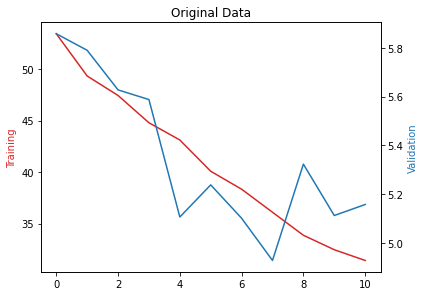

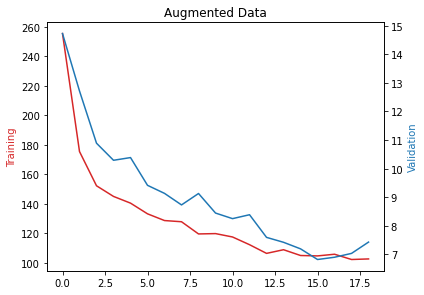

In [29]:
plot_train_val(train_history_original, valid_history_original,"Original Data")
plot_train_val(train_history, valid_history,"Augmented Data")

We can also compare accuracy between models.

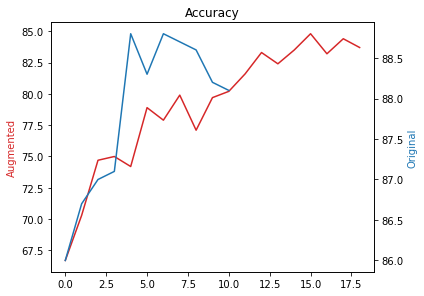

In [30]:
plot_train_val(accuracy_history, accuracy_history_original,"Accuracy",label1='Augmented',label2='Original')

#### Verifying models with Testing Dataset

Finally, let's check the results by applying our model to the test dataset.

In [31]:
# put model in evaluation mode
model.eval()
# moving model to cpu for inference 
model.to('cpu')

# creating arrays to save predictions
y_true = []
y_pred = []
images_ = []
# disable all gradients things
with torch.no_grad():
        for data in iter(testloader):
            images, labels = data
            outputs = model(images)
            for i in range(outputs.shape[0]):
                images_.append(images[i].unsqueeze(0))
                ps = torch.exp(outputs[i])
                y_pred.append(np.argmax(ps))
                y_true.append(labels[i].item())


Firstly, let's examine the confusion matrix.

Confusion matrix


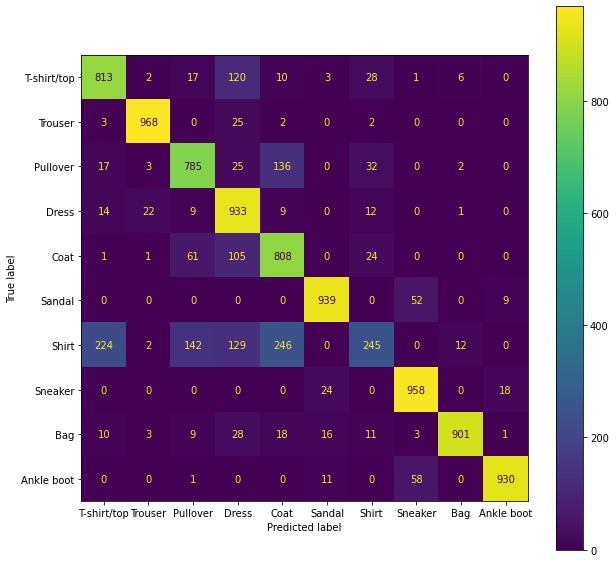

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

print("Confusion matrix")
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_text)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

We can also plot some of the results of the test dataset.

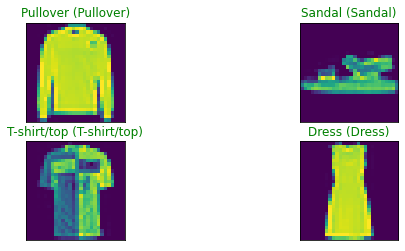

In [33]:
# plotting the results
fig = plt.figure(figsize=(n_images+5,4))
for i in range(n_images):
    ax = fig.add_subplot(2, n_images/2, i+1, xticks=[], yticks=[])
    ax.imshow(images_[i].resize_(1, 28, 28).numpy().squeeze())
    ax.set_title("{} ({})".format(labels_text[y_pred[i]], labels_text[y_true[i]]),
                 color=("green" if y_pred[i]==y_true[i] else "red"))

Not bad! But could you spot a problem with the algorithm? **Here's a tip**: we were very conservative when choosing the parameters of our algorithm, namely the number of compositions generated **C**, number of compositions  selected **S**, the number of linear transforms per composition **L** and the magnitude **M** of the chosen transforms.

> **What do you think would happen if we increased those values?** If you have time, you can try to play with the values.

### Shortcomings of the Algorithm

It is possible that the transforms applied on an image are so severe that the image becomes indistinguishable, losing its target information. In such a case, we would end up feeding the model pure noise. However, pure noise yields a high loss when fed into the model, so using **MuAugment** selects for those unrecognizable images if they are created. There’s no simple solution for this issue other than to choose appropriate hyperparameters so as to reduce the generation of inscrutable images, so it’s a good idea to keep the number of transforms in a composition **C** under 4 and the magnitude of each transform **M** under 6.

As a heuristic, larger models and datasets require more regularization and would accordingly perform better with a greater magnitude **M**. This is because bigger models are more prone to overfit and lengthier datasets have a higher signal-to-noise ratio which should be reduced to an optimal point.